In [ ]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
!pip install transformers datasets librosa torchcodec tqdm -q
import os
import shutil
from tqdm.notebook import tqdm
import os, sys, numpy as np, pandas as pd
from transformers import Wav2Vec2ForSequenceClassification, Wav2Vec2FeatureExtractor, TrainingArguments, Trainer
from datasets import Dataset, Audio
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

Looking in indexes: https://download.pytorch.org/whl/cu121
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 27.6 MB/s eta 0:00:00


In [ ]:
# Mount Google Drive, copy audio data to /content, show progress
from google.colab import drive
drive.mount('/content/drive')

src_folder = "/content/drive/MyDrive/Colab Notebooks/ETSP/data"
dst_folder = "/content/data_local"

if not os.path.exists(dst_folder):
    os.makedirs(dst_folder)

# nested progress bars
for dialect_folder in tqdm(os.listdir(src_folder), desc="Copying dialect folders", leave=True):
    src_dialect = os.path.join(src_folder, dialect_folder)
    dst_dialect = os.path.join(dst_folder, dialect_folder)
    if not os.path.exists(dst_dialect):
        os.makedirs(dst_dialect)

    audio_files = [f for f in os.listdir(src_dialect) if f.endswith('.wav')]
    for fname in tqdm(audio_files, desc=f"Copying {dialect_folder}", leave=False):
        shutil.copy2(os.path.join(src_dialect, fname), os.path.join(dst_dialect, fname))


# Set up local path for all downstream code
audio_root = '/content/data_local'

#TODO: try zipping if this is too slow

Mounted at /content/drive


Copying dialect folders:   0%|          | 0/8 [00:00<?, ?it/s]

Copying lu:   0%|          | 0/2715 [00:00<?, ?it/s]

Copying ag:   0%|          | 0/2748 [00:00<?, ?it/s]

Copying bs:   0%|          | 0/2713 [00:00<?, ?it/s]

Copying gr:   0%|          | 0/2749 [00:00<?, ?it/s]

Copying be:   0%|          | 0/2700 [00:00<?, ?it/s]

Copying sg:   0%|          | 0/2752 [00:00<?, ?it/s]

Copying zh:   0%|          | 0/4065 [00:00<?, ?it/s]

Copying vs:   0%|          | 0/2753 [00:00<?, ?it/s]

In [ ]:
os.environ["WANDB_DISABLED"] = "true"

# Ensure you can import your utility scripts
sys.path.append('/content/drive/MyDrive/Colab Notebooks/ETSP/utils')
from prepare_dataset import make_datasets, make_audio_splits

file_path = '/content/drive/MyDrive/Colab Notebooks/ETSP/sentences_ch_de_transcribed.json'
dialects = ['ch_sg', 'ch_be', 'ch_gr', 'ch_zh', 'ch_vs', 'ch_bs', 'ch_ag', 'ch_lu']

_, _, _, dialect2label, train_ids, val_ids, test_ids = make_datasets(file_path, dialects)
train_audio_df, val_audio_df, test_audio_df = make_audio_splits(audio_root, dialects, dialect2label, train_ids, val_ids, test_ids)


In [ ]:
import soundfile as sf

for i in range(10):
    path = train_audio_df.iloc[i]["audio_path"]
    try:
        data, sr = sf.read(path)
        print(f"{path}: OK, shape={data.shape}, sr={sr}")
    except Exception as e:
        print(f"ERROR with file {path}: {e}")


/content/data_local/sg/ch_sg_0000.wav: OK, shape=(111573,), sr=22050
/content/data_local/sg/ch_sg_0003.wav: OK, shape=(95800,), sr=22050
/content/data_local/sg/ch_sg_0004.wav: OK, shape=(220059,), sr=22050
/content/data_local/sg/ch_sg_0005.wav: OK, shape=(133983,), sr=22050
/content/data_local/sg/ch_sg_0008.wav: OK, shape=(169785,), sr=22050
/content/data_local/sg/ch_sg_0011.wav: OK, shape=(142002,), sr=22050
/content/data_local/sg/ch_sg_0012.wav: OK, shape=(195219,), sr=22050
/content/data_local/sg/ch_sg_0013.wav: OK, shape=(127449,), sr=22050
/content/data_local/sg/ch_sg_0014.wav: OK, shape=(109427,), sr=22050
/content/data_local/sg/ch_sg_0017.wav: OK, shape=(85591,), sr=22050


In [ ]:
train_dataset = Dataset.from_pandas(train_audio_df)
val_dataset = Dataset.from_pandas(val_audio_df)
test_dataset = Dataset.from_pandas(test_audio_df)


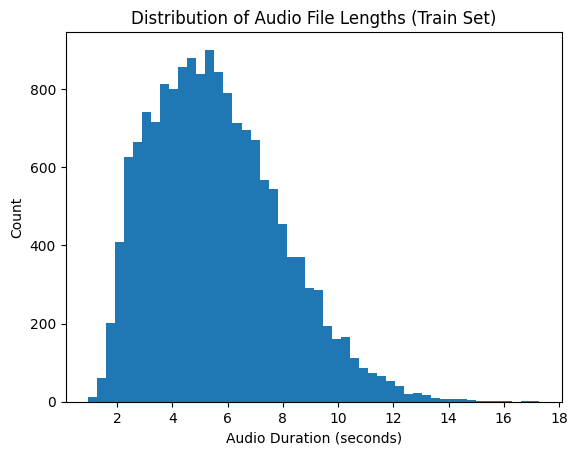

95th percentile: 9.89 seconds
Max file length: 17.28 seconds


In [ ]:
import soundfile as sf
import matplotlib.pyplot as plt

lengths = []
for path in train_audio_df["audio_path"]:
    wav, sr = sf.read(path)
    lengths.append(len(wav))  # raw sample count

# Convert to seconds (using assumed sr, or keep as samples)
lengths_sec = [l/16000.0 for l in lengths]  # adjust if your sample rate is not 16k!

plt.hist(lengths_sec, bins=50)
plt.xlabel("Audio Duration (seconds)")
plt.ylabel("Count")
plt.title("Distribution of Audio File Lengths (Train Set)")
plt.show()

print(f"95th percentile: {np.percentile(lengths_sec, 95):.2f} seconds")
print(f"Max file length: {max(lengths_sec):.2f} seconds")

In [ ]:
model_name = "facebook/wav2vec2-base"
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(model_name)

max_length_samples = 160_000  # 10 seconds at 16kHz

def preprocess_audio(batch):
    audio_arrays = []
    for path in batch["audio_path"]:
        wav, sr = sf.read(path, dtype='float32')
        # Resample to 16kHz if sr != 16000, if needed!
        audio_arrays.append(wav)
    features = feature_extractor(
        audio_arrays,
        sampling_rate=16000,
        padding="max_length",
        max_length=max_length_samples,
        truncation=True,
        return_tensors=None
    )
    return {"input_values": features["input_values"], "label": batch["label"]}



/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

In [ ]:
train_dataset = train_dataset.map(preprocess_audio, batched=True, batch_size=8, num_proc=1, load_from_cache_file=False, remove_columns=["audio_path"])
val_dataset = val_dataset.map(preprocess_audio, batched=True, batch_size=8, num_proc=1, load_from_cache_file=False, remove_columns=["audio_path"])
test_dataset = test_dataset.map(preprocess_audio, batched=True, batch_size=8, num_proc=1, load_from_cache_file=False, remove_columns=["audio_path"])


Map:   0%|          | 0/16176 [00:00<?, ? examples/s]

Map:   0%|          | 0/2024 [00:00<?, ? examples/s]

Map:   0%|          | 0/2024 [00:00<?, ? examples/s]

In [ ]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    accuracy = (preds == labels).mean()
    report = classification_report(labels, preds, target_names=list(label2dialect.values()), output_dict=True)
    metrics = {
        'accuracy': accuracy,
        'macro_f1': report['macro avg']['f1-score']
    }
    for i, dialect in label2dialect.items():
        metrics[f'f1_{dialect}'] = report[dialect]['f1-score']
        metrics[f'precision_{dialect}'] = report[dialect]['precision']
        metrics[f'recall_{dialect}'] = report[dialect]['recall']
    return metrics

In [ ]:
label2dialect = {i: d for d, i in dialect2label.items()}
model = Wav2Vec2ForSequenceClassification.from_pretrained(model_name, num_labels=len(dialects))

training_args = TrainingArguments(
    output_dir="./wav2vec2-swissdial-results",
    per_device_train_batch_size=128,  # Increase to 16, 24, 32 if RAM/VRAM allows
    per_device_eval_batch_size=128,
    dataloader_num_workers=8,        # Try 4 or 8 if really fast disk/CPU
    eval_strategy="epoch",
    num_train_epochs=3,
    save_strategy="epoch",
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_dir="./logs",
    load_best_model_at_end=True,
    fp16=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

trainer.train()

/usr/local/lib/python3.12/dist-packages/transformers/configuration_utils.py:335: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,F1 Ch Sg,Precision Ch Sg,Recall Ch Sg,F1 Ch Be,Precision Ch Be,Recall Ch Be,F1 Ch Gr,Precision Ch Gr,Recall Ch Gr,F1 Ch Zh,Precision Ch Zh,Recall Ch Zh,F1 Ch Vs,Precision Ch Vs,Recall Ch Vs,F1 Ch Bs,Precision Ch Bs,Recall Ch Bs,F1 Ch Ag,Precision Ch Ag,Recall Ch Ag,F1 Ch Lu,Precision Ch Lu,Recall Ch Lu
1,No log,0.543584,0.996542,0.996542,1.000000,1.000000,1.000000,0.998020,1.000000,0.996047,0.996032,1.000000,0.992095,0.996063,0.992157,1.000000,0.996063,0.992157,1.000000,0.998020,1.000000,0.996047,0.994059,0.996032,0.992095,0.994083,0.992126,0.996047


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,F1 Ch Sg,Precision Ch Sg,Recall Ch Sg,F1 Ch Be,Precision Ch Be,Recall Ch Be,F1 Ch Gr,Precision Ch Gr,Recall Ch Gr,F1 Ch Zh,Precision Ch Zh,Recall Ch Zh,F1 Ch Vs,Precision Ch Vs,Recall Ch Vs,F1 Ch Bs,Precision Ch Bs,Recall Ch Bs,F1 Ch Ag,Precision Ch Ag,Recall Ch Ag,F1 Ch Lu,Precision Ch Lu,Recall Ch Lu
1,No log,0.543584,0.996542,0.996542,1.000000,1.000000,1.000000,0.998020,1.000000,0.996047,0.996032,1.000000,0.992095,0.996063,0.992157,1.000000,0.996063,0.992157,1.000000,0.998020,1.000000,0.996047,0.994059,0.996032,0.992095,0.994083,0.992126,0.996047
2,No log,0.246297,0.999506,0.999506,0.998028,0.996063,1.000000,1.000000,1.000000,1.000000,0.998020,1.000000,0.996047,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
3,No log,0.192846,0.999012,0.999012,0.998028,0.996063,1.000000,0.998020,1.000000,0.996047,0.998020,1.000000,0.996047,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.998028,0.996063,1.000000,1.000000,1.000000,1.000000


TrainOutput(global_step=381, training_loss=0.6383124724460711, metrics={'train_runtime': 1029.4353, 'train_samples_per_second': 47.14, 'train_steps_per_second': 0.37, 'total_flos': 4.40575068450816e+18, 'train_loss': 0.6383124724460711, 'epoch': 3.0})

Exception in thread Thread-17 (_pin_memory_loop):
Traceback (most recent call last):
  File "/usr/lib/python3.12/threading.py", line 1075, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.12/threading.py", line 1012, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/_utils/pin_memory.py", line 61, in _pin_memory_loop
    do_one_step()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/_utils/pin_memory.py", line 37, in do_one_step
    r = in_queue.get(timeout=MP_STATUS_CHECK_INTERVAL)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/queues.py", line 122, in get
    return _ForkingPickler.loads(res)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/torch/multiprocessing/reductions.py", line 541, in rebuild_storage_fd
    fd = df.detach()
         ^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/resource_

Test set metrics: {'eval_loss': 0.19269143044948578, 'eval_accuracy': 0.9995059288537549, 'eval_macro_f1': 0.9995059269240534, 'eval_f1_ch_sg': 0.9980276134122288, 'eval_precision_ch_sg': 0.9960629921259843, 'eval_recall_ch_sg': 1.0, 'eval_f1_ch_be': 1.0, 'eval_precision_ch_be': 1.0, 'eval_recall_ch_be': 1.0, 'eval_f1_ch_gr': 0.998019801980198, 'eval_precision_ch_gr': 1.0, 'eval_recall_ch_gr': 0.9960474308300395, 'eval_f1_ch_zh': 1.0, 'eval_precision_ch_zh': 1.0, 'eval_recall_ch_zh': 1.0, 'eval_f1_ch_vs': 1.0, 'eval_precision_ch_vs': 1.0, 'eval_recall_ch_vs': 1.0, 'eval_f1_ch_bs': 1.0, 'eval_precision_ch_bs': 1.0, 'eval_recall_ch_bs': 1.0, 'eval_f1_ch_ag': 1.0, 'eval_precision_ch_ag': 1.0, 'eval_recall_ch_ag': 1.0, 'eval_f1_ch_lu': 1.0, 'eval_precision_ch_lu': 1.0, 'eval_recall_ch_lu': 1.0, 'eval_runtime': 51.5368, 'eval_samples_per_second': 39.273, 'eval_steps_per_second': 0.31, 'epoch': 3.0}
Label mapping: {0: 'ch_sg', 1: 'ch_be', 2: 'ch_gr', 3: 'ch_zh', 4: 'ch_vs', 5: 'ch_bs', 6: 'c

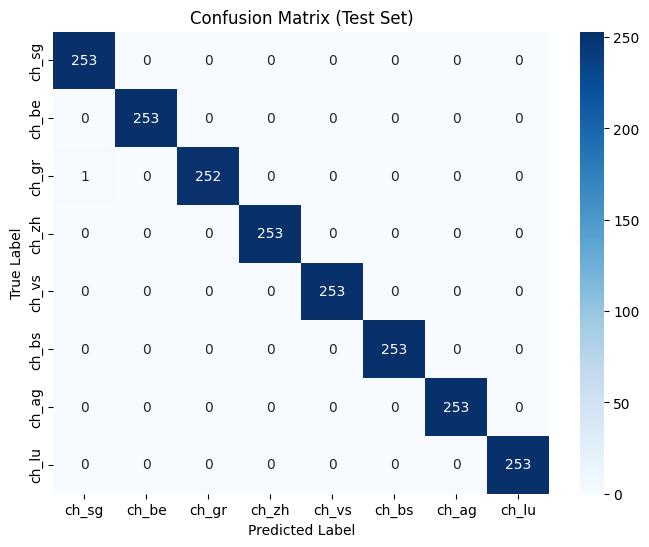

In [ ]:
results = trainer.evaluate(test_dataset)
print("Test set metrics:", results)
print("Label mapping:", label2dialect)

outputs = trainer.predict(test_dataset)
y_true = outputs.label_ids
y_pred = np.argmax(outputs.predictions, axis=-1)

print(classification_report(y_true, y_pred, target_names=list(label2dialect.values())))
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(label2dialect.values()), yticklabels=list(label2dialect.values()))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Test Set)')
plt.show()
